In [1]:
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade
!pip install tensorflow

  Obtaining dependency information for keras from https://files.pythonhosted.org/packages/b2/e4/30b53d839608d2212b97972a8516ba0c7e776ee1102eaa82624807b944cf/keras-3.0.1-py3-none-any.whl.metadata
  Using cached keras-3.0.1-py3-none-any.whl.metadata (4.8 kB)
Using cached keras-3.0.1-py3-none-any.whl (999 kB)
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.1 which is incompatible.


  Obtaining dependency information for keras<2.16,>=2.15.0 from https://files.pythonhosted.org/packages/fc/a7/0d4490de967a67f68a538cc9cdb259bff971c4b5787f7765dc7c8f118f71/keras-2.15.0-py3-none-any.whl.metadata
  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
  Attempting uninstall: keras
    Found existing installation: keras 3.0.1
    Uninstalling keras-3.0.1:
      Successfully uninstalled keras-3.0.1


In [2]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [5]:
# Specify the absolute path to the dataset
dataset_path = r"C:\Users\HP\Desktop\training.1600000.processed.noemoticon.csv"

# Print information about the dataset
print("Open file:", dataset_path)

# Read the dataset into a DataFrame
df = pd.read_csv(dataset_path, encoding=DATASET_ENCODING, names=DATASET_COLUMNS)


Open file: C:\Users\HP\Desktop\training.1600000.processed.noemoticon.csv


In [6]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [7]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [8]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [9]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: total: 125 ms
Wall time: 256 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

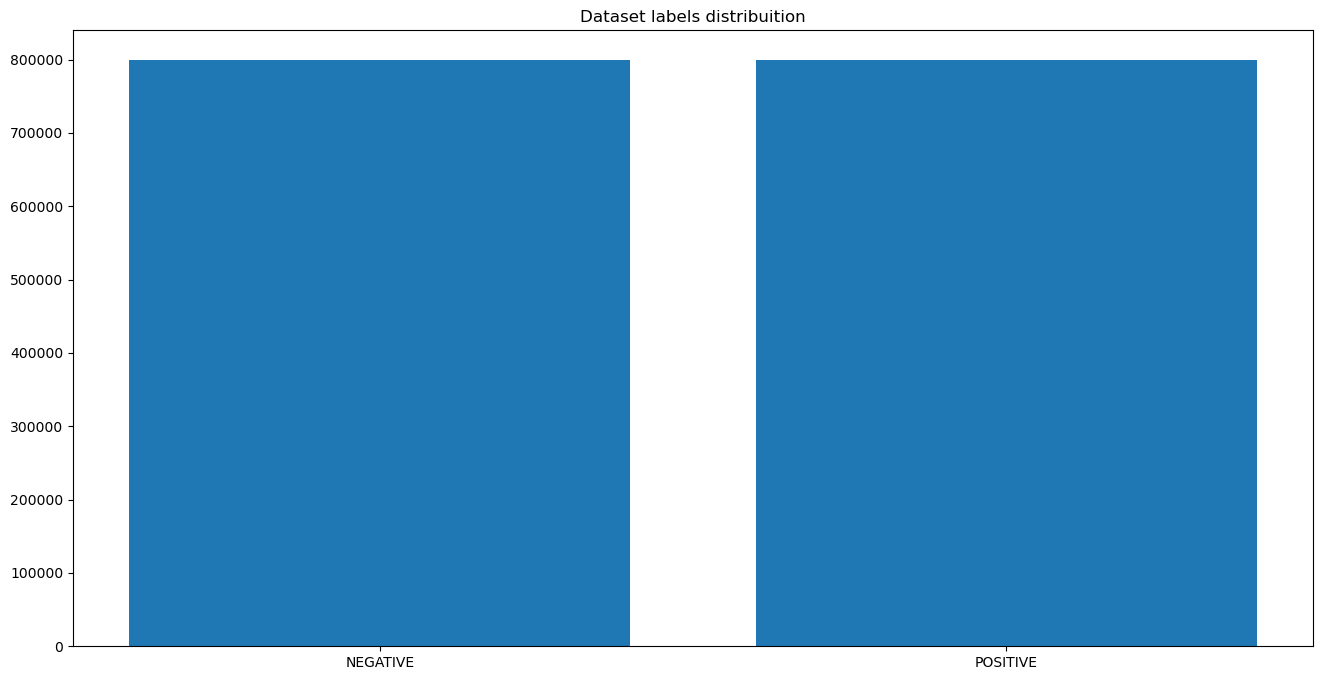

In [10]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [11]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [12]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [13]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: total: 31.5 s
Wall time: 1min 12s


In [14]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


In [15]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: total: 2.08 s
Wall time: 4.75 s


In [16]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)


2023-12-08 23:16:40,815 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=300, alpha=0.025>', 'datetime': '2023-12-08T23:16:40.815222', 'gensim': '4.3.2', 'python': '3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'created'}


In [17]:
w2v_model.build_vocab(documents)

2023-12-08 23:16:45,585 : INFO : collecting all words and their counts
2023-12-08 23:16:45,587 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2023-12-08 23:16:45,613 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2023-12-08 23:16:45,631 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2023-12-08 23:16:45,648 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2023-12-08 23:16:45,665 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2023-12-08 23:16:45,695 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2023-12-08 23:16:45,720 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2023-12-08 23:16:45,738 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2023-12-08 23:16:45,753 : INFO : PROGRESS: at s

In [18]:
# Change the following line in Cell-20
# words = w2v_model.wv.vocab.keys()

# To the following, using key_to_index
words = list(w2v_model.wv.key_to_index.keys())

# Rest of the code remains unchanged
vocab_size = len(words)
print("Vocab size", vocab_size)


Vocab size 30369


In [19]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2023-12-08 23:17:13,740 : INFO : Word2Vec lifecycle event {'msg': 'training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7 shrink_windows=True', 'datetime': '2023-12-08T23:17:13.740719', 'gensim': '4.3.2', 'python': '3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'train'}
2023-12-08 23:17:14,772 : INFO : EPOCH 0 - PROGRESS: at 17.46% examples, 1433789 words/s, in_qsize 15, out_qsize 0
2023-12-08 23:17:15,773 : INFO : EPOCH 0 - PROGRESS: at 37.48% examples, 1540689 words/s, in_qsize 15, out_qsize 0
2023-12-08 23:17:16,771 : INFO : EPOCH 0 - PROGRESS: at 57.27% examples, 1570434 words/s, in_qsize 16, out_qsize 0
2023-12-08 23:17:17,774 : INFO : EPOCH 0 - PROGRESS: at 76.98% examples, 1582524 words/s, in_qsize 15, out_qsize 0
2023-12-08 23:17:18,779 : INFO : EPOCH 0 - PROGRESS: at 97.40% examples, 1599541 words/s, in_qsize 15, ou

CPU times: total: 7min 57s
Wall time: 2min 44s


(263127567, 295270528)

In [20]:
# Use the "wv" attribute to access the Word2VecKeyedVectors
similar_words = w2v_model.wv.most_similar("love")

# Print each element on a new line without rounding
for word, similarity in similar_words:
    print(f"('{word}', {similarity})")


('luv', 0.586133599281311)
('loves', 0.5650420188903809)
('loved', 0.5204981565475464)
('adore', 0.5128191113471985)
('amazing', 0.5046751499176025)
('looove', 0.4771042764186859)
('awesome', 0.464685320854187)
('loveee', 0.4486897587776184)
('lovee', 0.44329047203063965)
('loooove', 0.44275015592575073)


In [21]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: total: 12.9 s
Wall time: 18.4 s


In [22]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: total: 14.4 s
Wall time: 36.4 s


In [23]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [24]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [25]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [26]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [27]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [28]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

2023-12-08 23:23:56,345 : WARNING : From C:\Users\HP\anaconda3\Lib\site-packages\keras\src\backend.py:873: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [29]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          87125700  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 87286201 (332.97 MB)
Trainable params: 160501 (626.96 KB)
Non-trainable params: 87125700 (332.36 MB)
_________________________________________________________________


In [30]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

2023-12-08 23:24:26,593 : WARNING : From C:\Users\HP\anaconda3\Lib\site-packages\keras\src\optimizers\__init__.py:309: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [31]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [32]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8



2023-12-08 23:25:01,634 : WARNING : From C:\Users\HP\anaconda3\Lib\site-packages\keras\src\utils\tf_utils.py:492: The name tf.ragged.RaggedTensorValue is deprecated. Please use tf.compat.v1.ragged.RaggedTensorValue instead.



2023-12-08 23:25:02,598 : WARNING : From C:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\base_layer_utils.py:384: The name tf.executing_eagerly_outside_functions is deprecated. Please use tf.compat.v1.executing_eagerly_outside_functions instead.



1125/1125 [==============================] - ETA: 0s - loss: 0.5128 - accuracy: 0.7440WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2023-12-09 00:50:46,558 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 5146s 5s/step - loss: 0.5128 - accuracy: 0.7440 - val_loss: 0.4681 - val_accuracy: 0.7768 - lr: 0.0010
Epoch 2/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4826 - accuracy: 0.7650WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2023-12-09 02:18:19,755 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 5253s 5s/step - loss: 0.4826 - accuracy: 0.7650 - val_loss: 0.4606 - val_accuracy: 0.7818 - lr: 0.0010
Epoch 3/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4745 - accuracy: 0.7702WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2023-12-09 03:15:19,038 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 3419s 3s/step - loss: 0.4745 - accuracy: 0.7702 - val_loss: 0.4558 - val_accuracy: 0.7845 - lr: 0.0010
Epoch 4/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4704 - accuracy: 0.7730WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2023-12-09 03:59:56,015 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 2677s 2s/step - loss: 0.4704 - accuracy: 0.7730 - val_loss: 0.4527 - val_accuracy: 0.7870 - lr: 0.0010
Epoch 5/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4680 - accuracy: 0.7741WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2023-12-09 04:45:21,987 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 2726s 2s/step - loss: 0.4680 - accuracy: 0.7741 - val_loss: 0.4501 - val_accuracy: 0.7877 - lr: 0.0010
Epoch 6/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4654 - accuracy: 0.7759WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2023-12-09 05:31:14,060 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 2752s 2s/step - loss: 0.4654 - accuracy: 0.7759 - val_loss: 0.4486 - val_accuracy: 0.7882 - lr: 0.0010
Epoch 7/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4638 - accuracy: 0.7769WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2023-12-09 06:17:11,528 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 2757s 2s/step - loss: 0.4638 - accuracy: 0.7769 - val_loss: 0.4479 - val_accuracy: 0.7890 - lr: 0.0010
Epoch 8/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4624 - accuracy: 0.7778WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2023-12-09 07:03:09,071 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 2758s 2s/step - loss: 0.4624 - accuracy: 0.7778 - val_loss: 0.4467 - val_accuracy: 0.7895 - lr: 0.0010
CPU times: total: 17h 24min 1s
Wall time: 7h 38min 11s


In [33]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 [==============================] - 103s 327ms/step - loss: 0.4458 - accuracy: 0.7900

ACCURACY: 0.7899875044822693
LOSS: 0.44583770632743835
CPU times: total: 1min 20s
Wall time: 1min 43s


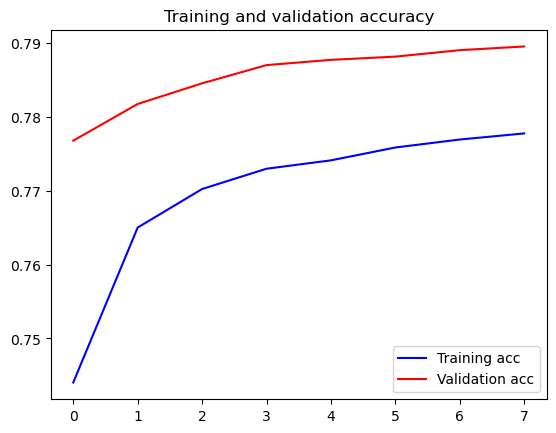

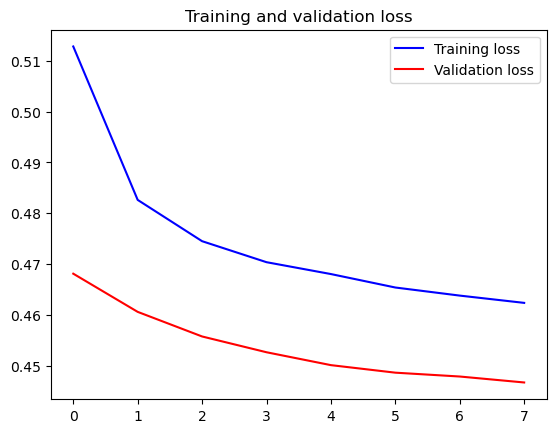

In [35]:
# Corrected code
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [71]:
SENTIMENT_THRESHOLDS = (0.4, 0.8)

In [72]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:
        if score <= SENTIMENT_THRESHOLDS[0]:
            return NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            return POSITIVE
        else:
            return NEUTRAL
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [73]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    print("Raw Score:", score)  # Print raw score for debugging purposes
    # Decode sentiment with include_neutral
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
            "elapsed_time": time.time()-start_at} 

In [74]:
output = predict("The book is on the shelf.", include_neutral=True)
print(output)

1/1 [==============================] - 0s 36ms/step
Raw Score: [0.7418885]
{'label': 'NEUTRAL', 'score': 0.7418885231018066, 'elapsed_time': 0.0655984878540039}


In [75]:
output = predict("The book is on the shelf.", include_neutral=True)
print(output)

1/1 [==============================] - 0s 40ms/step
Raw Score: [0.7418885]
{'label': 'NEUTRAL', 'score': 0.7418885231018066, 'elapsed_time': 0.07856535911560059}


In [76]:
predict("i don't know what i'm doing")

1/1 [==============================] - 0s 39ms/step
Raw Score: [0.31051418]


{'label': 'NEGATIVE',
 'score': 0.3105141818523407,
 'elapsed_time': 0.06924057006835938}

In [77]:
predict("I'm really disappointed with the service at this hotel.")

1/1 [==============================] - 0s 42ms/step
Raw Score: [0.00747176]


{'label': 'NEGATIVE',
 'score': 0.00747176306322217,
 'elapsed_time': 0.07485532760620117}

In [78]:
predict("I'm really disappointed with the service at this hotel.")

1/1 [==============================] - 0s 40ms/step
Raw Score: [0.00747176]


{'label': 'NEGATIVE',
 'score': 0.00747176306322217,
 'elapsed_time': 0.06961631774902344}

In [79]:
predict("The book is on the shelf.")

1/1 [==============================] - 0s 38ms/step
Raw Score: [0.7418885]


{'label': 'NEUTRAL',
 'score': 0.7418885231018066,
 'elapsed_time': 0.06888842582702637}

In [80]:
predict("The book is not on the shelf.")

1/1 [==============================] - 0s 35ms/step
Raw Score: [0.7418885]


{'label': 'NEUTRAL',
 'score': 0.7418885231018066,
 'elapsed_time': 0.06622433662414551}

In [84]:
predict("I enjoy watching documentaries.")

1/1 [==============================] - 0s 31ms/step
Raw Score: [0.9900706]


{'label': 'POSITIVE',
 'score': 0.9900705814361572,
 'elapsed_time': 0.08870315551757812}

In [82]:
print(SENTIMENT_THRESHOLDS[0])

0.4


In [83]:
print(SENTIMENT_THRESHOLDS[1])

0.8


In [86]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score[0], include_neutral=False) for score in scores]

40/40 [==============================] - 85s 2s/step
CPU times: total: 4min 50s
Wall time: 1min 26s


In [87]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

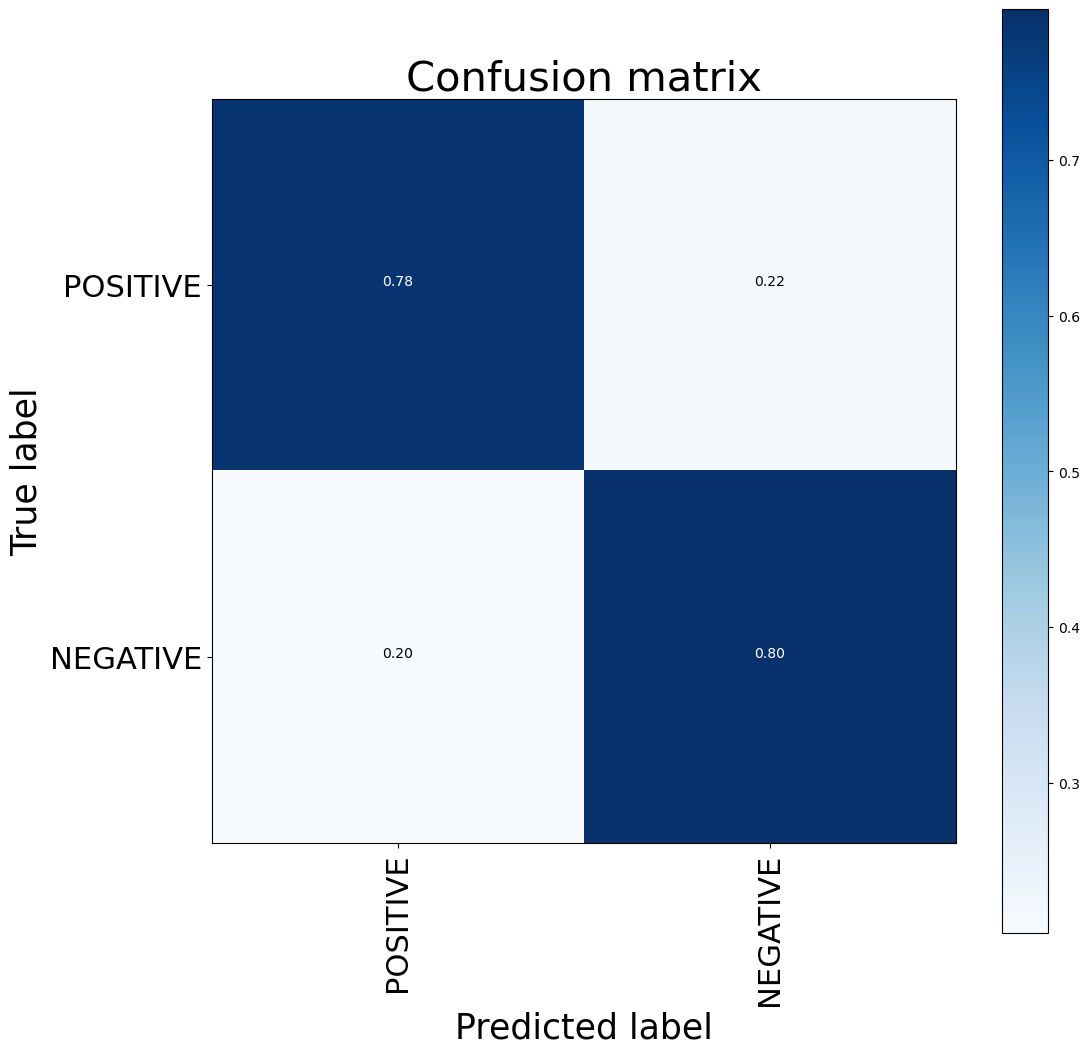

CPU times: total: 438 ms
Wall time: 1.02 s


In [88]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [89]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
print("Confusion Matrix:")
print(cnf_matrix)

Confusion Matrix:
[[124925  34569]
 [ 32635 127871]]


In [90]:
# Extract values from confusion matrix
TP, FP, FN, TN = cnf_matrix.ravel()

# Calculate metrics
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")


Accuracy: 0.7900
Precision: 0.7833
Recall: 0.7929
F1 Score: 0.7880


In [91]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.79      0.78      0.79    159494
    POSITIVE       0.79      0.80      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



In [92]:
accuracy_score(y_test_1d, y_pred_1d)

0.7899875

In [93]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

C:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
2023-12-09 09:50:50,867 : INFO : Word2Vec lifecycle event {'fname_or_handle': 'model.w2v', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2023-12-09T09:50:50.852169', 'gensim': '4.3.2', 'python': '3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'saving'}
2023-12-09 09:50:50,867 : INFO : not storing attribute cum_table
2023-12-09 09:50:51,710 : INFO : saved model.w2v


In [94]:
import os
print(os.getcwd())


C:\Users\HP


In [2]:
from keras.models import load_model
import gensim
import pickle

# Load Keras Model
loaded_model = load_model('model.h5')

# Load Word2Vec Model
loaded_w2v_model = gensim.models.Word2Vec.load('model.w2v')

# Load Tokenizer
with open('tokenizer.pkl', 'rb') as file:
    loaded_tokenizer = pickle.load(file)

# Load Label Encoder
with open('encoder.pkl', 'rb') as file:
    loaded_encoder = pickle.load(file)


In [21]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = loaded_model.predict([x_test])[0]
    print("Raw Score:", score)  # Print raw score for debugging purposes
    # Decode sentiment with include_neutral
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
            "elapsed_time": time.time()-start_at} 

In [20]:
predict("I enjoy watching documentaries.")

1/1 [==============================] - 0s 84ms/step
Raw Score: [0.978851]


{'label': 'POSITIVE',
 'score': 0.9788510203361511,
 'elapsed_time': 0.14308738708496094}

In [4]:
import time

In [3]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import tqdm
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [7]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 594849
CPU times: total: 5.97 s
Wall time: 14.5 s


In [6]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


In [5]:
# Specify the absolute path to the dataset
dataset_path = r"C:\Users\HP\Desktop\training.1600000.processed.noemoticon.csv"

# Print information about the dataset
print("Open file:", dataset_path)

# Read the dataset into a DataFrame
df = pd.read_csv(dataset_path, encoding=DATASET_ENCODING, names=DATASET_COLUMNS)


Open file: C:\Users\HP\Desktop\training.1600000.processed.noemoticon.csv


In [4]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [8]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:
        if score <= SENTIMENT_THRESHOLDS[0]:
            return NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            return POSITIVE
        else:
            return NEUTRAL
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [13]:
predict("The book is on the shelf.")

1/1 [==============================] - 0s 31ms/step
Raw Score: [0.3615023]


{'label': 'NEGATIVE',
 'score': 0.3615022897720337,
 'elapsed_time': 0.06374692916870117}

In [11]:
predict("I really liked that movie.")

1/1 [==============================] - 0s 214ms/step
Raw Score: [0.8145949]


{'label': 'POSITIVE',
 'score': 0.8145949244499207,
 'elapsed_time': 0.267749547958374}

In [12]:
predict("I am not able to pass this exam. #sad_life")

1/1 [==============================] - 0s 33ms/step
Raw Score: [0.9669607]


{'label': 'POSITIVE',
 'score': 0.9669607281684875,
 'elapsed_time': 0.07051825523376465}

In [38]:
predict("I am not that amused")

1/1 [==============================] - 0s 29ms/step
Raw Score: [0.7464534]


{'label': 'POSITIVE',
 'score': 0.7464534044265747,
 'elapsed_time': 0.05935478210449219}

In [30]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = loaded_model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score[0], include_neutral=False) for score in scores]

InvalidArgumentError: Graph execution error:

Detected at node sequential/embedding/embedding_lookup defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\HP\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\HP\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\HP\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 736, in start

  File "C:\Users\HP\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\HP\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\HP\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\HP\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\HP\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue

  File "C:\Users\HP\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one

  File "C:\Users\HP\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell

  File "C:\Users\HP\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request

  File "C:\Users\HP\anaconda3\Lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute

  File "C:\Users\HP\anaconda3\Lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell

  File "C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell

  File "C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell

  File "C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async

  File "C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes

  File "C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code

  File "C:\Users\HP\AppData\Local\Temp\ipykernel_11396\3879598413.py", line 1, in <module>

  File "C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 2493, in run_cell_magic

  File "C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\magics\execution.py", line 1340, in time

  File "<timed exec>", line 3, in <module>

  File "C:\Users\HP\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2655, in predict

  File "C:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2440, in predict_function

  File "C:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2425, in step_function

  File "C:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2413, in run_step

  File "C:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2381, in predict_step

  File "C:\Users\HP\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 590, in __call__

  File "C:\Users\HP\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "C:\Users\HP\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "C:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\sequential.py", line 398, in call

  File "C:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\functional.py", line 515, in call

  File "C:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\functional.py", line 672, in _run_internal_graph

  File "C:\Users\HP\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "C:\Users\HP\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py", line 272, in call

indices[6848,284] = 561209 is not in [0, 290419)
	 [[{{node sequential/embedding/embedding_lookup}}]] [Op:__inference_predict_function_1790]

In [27]:
%%time
score = loaded_model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

2023-12-09 23:57:55,963 : WARNING : From C:\Users\HP\anaconda3\Lib\site-packages\keras\src\utils\tf_utils.py:492: The name tf.ragged.RaggedTensorValue is deprecated. Please use tf.compat.v1.ragged.RaggedTensorValue instead.



InvalidArgumentError: Graph execution error:

Detected at node sequential/embedding/embedding_lookup defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\HP\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\HP\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\HP\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 736, in start

  File "C:\Users\HP\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\HP\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\HP\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\HP\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\HP\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue

  File "C:\Users\HP\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one

  File "C:\Users\HP\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell

  File "C:\Users\HP\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request

  File "C:\Users\HP\anaconda3\Lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute

  File "C:\Users\HP\anaconda3\Lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell

  File "C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell

  File "C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell

  File "C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async

  File "C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes

  File "C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code

  File "C:\Users\HP\AppData\Local\Temp\ipykernel_11396\3126587349.py", line 1, in <module>

  File "C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 2493, in run_cell_magic

  File "C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\magics\execution.py", line 1340, in time

  File "<timed exec>", line 1, in <module>

  File "C:\Users\HP\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2296, in evaluate

  File "C:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 4108, in run_step

  File "C:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2066, in test_function

  File "C:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2049, in step_function

  File "C:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2037, in run_step

  File "C:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1917, in test_step

  File "C:\Users\HP\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 590, in __call__

  File "C:\Users\HP\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "C:\Users\HP\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "C:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\sequential.py", line 398, in call

  File "C:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\functional.py", line 515, in call

  File "C:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\functional.py", line 672, in _run_internal_graph

  File "C:\Users\HP\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "C:\Users\HP\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py", line 272, in call

indices[380,292] = 315798 is not in [0, 290419)
	 [[{{node sequential/embedding/embedding_lookup}}]] [Op:__inference_test_function_1470]

In [24]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: total: 6.78 s
Wall time: 16.4 s


In [26]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)
